# Neural Net Language models

> Basic neuralnet-based language modeling 

In [ ]:
#| default_exp models.lm

In [ ]:
#| hide
%load_ext autoreload
%autoreload 2
from nbdev.showdoc import *

In [ ]:
#| export
import torch.nn as nn
import torch
import torch.nn.functional as F
from torch.optim import SGD
from torch.optim.optimizer import Optimizer
from torch.utils.data import DataLoader

import lightning as L
from lightning import Trainer

from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
from tqdm import tqdm

from omegaconf import OmegaConf
from hydra.utils import instantiate

from typing import Dict, List, Tuple, Optional, Set
from dataclasses import dataclass, asdict

from nimrod.text.datasets import CharDataset, Vocab

# N_EPOCHS for training debuggging
ITER_MAX = 5

/Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/torchtext/vocab/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/torchtext/utils.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IPr

In [ ]:
# reading with pandas
df = pd.read_csv('../data/text/names.txt', header=None, names=['name'])
data = list(df.name)
print("names: ", data[:3])

# reading directly in plain python
lines = []
with open('../data/text/tiny_shakespeare.txt', 'r', encoding='utf-8') as f:
    for line in f.readlines():
        if line.strip():
            # only append non blank lines
            lines.append(line)

# add special tokens
data = [['<bos>'] +list(line.strip()) + ['<eos>'] for line in lines]
print("shakespeare: ", data[:3])

v = Vocab('../data/text/tiny_shakespeare.txt')
print(v.stoi('e'))
print(v.itos(8))
print("pad: ", v.stoi('<pad>'))
print(v.stoi(['e','m']))
print(v.itos([8,17]))
print(len(v))
print(''.join(v.vocabulary))

names:  ['emma', 'olivia', 'ava']
shakespeare:  [['<bos>', 'F', 'i', 'r', 's', 't', ' ', 'C', 'i', 't', 'i', 'z', 'e', 'n', ':', '<eos>'], ['<bos>', 'B', 'e', 'f', 'o', 'r', 'e', ' ', 'w', 'e', ' ', 'p', 'r', 'o', 'c', 'e', 'e', 'd', ' ', 'a', 'n', 'y', ' ', 'f', 'u', 'r', 't', 'h', 'e', 'r', ',', ' ', 'h', 'e', 'a', 'r', ' ', 'm', 'e', ' ', 's', 'p', 'e', 'a', 'k', '.', '<eos>'], ['<bos>', 'A', 'l', 'l', ':', '<eos>']]
6
t
pad:  0
[6, 20]
['t', 'l']
70
 !$&',-.3:;<<bos><eos><pad><unk>>?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz


In [ ]:
# print first 4 lines of the file
for i in range(4):
    print(data[i])

['<bos>', 'F', 'i', 'r', 's', 't', ' ', 'C', 'i', 't', 'i', 'z', 'e', 'n', ':', '<eos>']
['<bos>', 'B', 'e', 'f', 'o', 'r', 'e', ' ', 'w', 'e', ' ', 'p', 'r', 'o', 'c', 'e', 'e', 'd', ' ', 'a', 'n', 'y', ' ', 'f', 'u', 'r', 't', 'h', 'e', 'r', ',', ' ', 'h', 'e', 'a', 'r', ' ', 'm', 'e', ' ', 's', 'p', 'e', 'a', 'k', '.', '<eos>']
['<bos>', 'A', 'l', 'l', ':', '<eos>']
['<bos>', 'S', 'p', 'e', 'a', 'k', ',', ' ', 's', 'p', 'e', 'a', 'k', '.', '<eos>']


In [ ]:
names = list(df.name)
print(len(names), names)

32033 ['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia', 'harper', 'evelyn', 'abigail', 'emily', 'elizabeth', 'mila', 'ella', 'avery', 'sofia', 'camila', 'aria', 'scarlett', 'victoria', 'madison', 'luna', 'grace', 'chloe', 'penelope', 'layla', 'riley', 'zoey', 'nora', 'lily', 'eleanor', 'hannah', 'lillian', 'addison', 'aubrey', 'ellie', 'stella', 'natalie', 'zoe', 'leah', 'hazel', 'violet', 'aurora', 'savannah', 'audrey', 'brooklyn', 'bella', 'claire', 'skylar', 'lucy', 'paisley', 'everly', 'anna', 'caroline', 'nova', 'genesis', 'emilia', 'kennedy', 'samantha', 'maya', 'willow', 'kinsley', 'naomi', 'aaliyah', 'elena', 'sarah', 'ariana', 'allison', 'gabriella', 'alice', 'madelyn', 'cora', 'ruby', 'eva', 'serenity', 'autumn', 'adeline', 'hailey', 'gianna', 'valentina', 'isla', 'eliana', 'quinn', 'nevaeh', 'ivy', 'sadie', 'piper', 'lydia', 'alexa', 'josephine', 'emery', 'julia', 'delilah', 'arianna', 'vivian', 'kaylee', 'sophie', 'brielle', 'madeline', 'peyton',

## Data formatting
given last n tokens we predict token n+1

In [ ]:
s = list("alexandra")
print(s)
bigram = [(x,y) for x, y in zip(s, s[1:])]
print(bigram)
trigram = [ (x,y,z) for x, y, z in zip(s, s[1:], s[2:])]
print(trigram)

['a', 'l', 'e', 'x', 'a', 'n', 'd', 'r', 'a']
[('a', 'l'), ('l', 'e'), ('e', 'x'), ('x', 'a'), ('a', 'n'), ('n', 'd'), ('d', 'r'), ('r', 'a')]
[('a', 'l', 'e'), ('l', 'e', 'x'), ('e', 'x', 'a'), ('x', 'a', 'n'), ('a', 'n', 'd'), ('n', 'd', 'r'), ('d', 'r', 'a')]


### Tiny shakespeare LM char dataset

In [ ]:

lines = []
with open('../data/text/tiny_shakespeare.txt', 'r', encoding='utf-8') as f:
    for line in f.readlines():
        if line.strip():
            # only append non blank lines
            lines.append(line)

# add special tokens
data = [['<bos>'] +list(line.strip()) + ['<eos>'] for line in lines]
print("shakespeare: ", data[:3])

v = Vocab('../data/text/tiny_shakespeare.txt')

shakespeare:  [['<bos>', 'F', 'i', 'r', 's', 't', ' ', 'C', 'i', 't', 'i', 'z', 'e', 'n', ':', '<eos>'], ['<bos>', 'B', 'e', 'f', 'o', 'r', 'e', ' ', 'w', 'e', ' ', 'p', 'r', 'o', 'c', 'e', 'e', 'd', ' ', 'a', 'n', 'y', ' ', 'f', 'u', 'r', 't', 'h', 'e', 'r', ',', ' ', 'h', 'e', 'a', 'r', ' ', 'm', 'e', ' ', 's', 'p', 'e', 'a', 'k', '.', '<eos>'], ['<bos>', 'A', 'l', 'l', ':', '<eos>']]


In [ ]:

def make_dataset(
        words:List[str], # data is a list of sentences which are a list of words
        v:Vocab,# vocabulary class for mapping words to indices
        verbose:bool=False, # print debug info
        context_length=3 # number of words/tokens to use as context
        ):
    X = []
    y = []
    for word in words:
        s = list(word)
        if verbose:
            print('row: ', s)
        # init prefix with padding while len < context_length
        for i in range(context_length-1):
            sequence = v.stoi(s[:i+1])
            pad_len = context_length - len(sequence)
            pad = [v.stoi("<pad>")] * pad_len
            X.append(pad + sequence)
            y.append(v.stoi(s[i+1]))

            if verbose:
                print(["<pad>"]+ s[:i+1], s[i+1])

        # for length seq = context_length
        i = 0
        while i < (len(s) - context_length):
            X.append(v.stoi(s[i:context_length+i]))
            y.append(v.stoi(s[i+context_length]))
            if verbose:
                print(s[i:context_length+i], s[i+context_length])
            i += 1
    return torch.tensor(X),torch.tensor(y)


In [ ]:
print(data[:2])

[['<bos>', 'F', 'i', 'r', 's', 't', ' ', 'C', 'i', 't', 'i', 'z', 'e', 'n', ':', '<eos>'], ['<bos>', 'B', 'e', 'f', 'o', 'r', 'e', ' ', 'w', 'e', ' ', 'p', 'r', 'o', 'c', 'e', 'e', 'd', ' ', 'a', 'n', 'y', ' ', 'f', 'u', 'r', 't', 'h', 'e', 'r', ',', ' ', 'h', 'e', 'a', 'r', ' ', 'm', 'e', ' ', 's', 'p', 'e', 'a', 'k', '.', '<eos>']]


for each row in the dataset we expand all the combinations of ngrams

In [ ]:
CONTEXT_LEN = 3
# from 2 rows/sentences of data we get 61 tri-grams & n+1 character prediction
X, y = make_dataset(data[:2], v, verbose=True, context_length=CONTEXT_LEN)
print("X: ", X.shape, "y:", y.shape)

row:  ['<bos>', 'F', 'i', 'r', 's', 't', ' ', 'C', 'i', 't', 'i', 'z', 'e', 'n', ':', '<eos>']
['<pad>', '<bos>'] F
['<pad>', '<bos>', 'F'] i
['<bos>', 'F', 'i'] r
['F', 'i', 'r'] s
['i', 'r', 's'] t
['r', 's', 't']  
['s', 't', ' '] C
['t', ' ', 'C'] i
[' ', 'C', 'i'] t
['C', 'i', 't'] i
['i', 't', 'i'] z
['t', 'i', 'z'] e
['i', 'z', 'e'] n
['z', 'e', 'n'] :
['e', 'n', ':'] <eos>
row:  ['<bos>', 'B', 'e', 'f', 'o', 'r', 'e', ' ', 'w', 'e', ' ', 'p', 'r', 'o', 'c', 'e', 'e', 'd', ' ', 'a', 'n', 'y', ' ', 'f', 'u', 'r', 't', 'h', 'e', 'r', ',', ' ', 'h', 'e', 'a', 'r', ' ', 'm', 'e', ' ', 's', 'p', 'e', 'a', 'k', '.', '<eos>']
['<pad>', '<bos>'] B
['<pad>', '<bos>', 'B'] e
['<bos>', 'B', 'e'] f
['B', 'e', 'f'] o
['e', 'f', 'o'] r
['f', 'o', 'r'] e
['o', 'r', 'e']  
['r', 'e', ' '] w
['e', ' ', 'w'] e
[' ', 'w', 'e']  
['w', 'e', ' '] p
['e', ' ', 'p'] r
[' ', 'p', 'r'] o
['p', 'r', 'o'] c
['r', 'o', 'c'] e
['o', 'c', 'e'] e
['c', 'e', 'e'] d
['e', 'e', 'd']  
['e', 'd', ' '] a
['d', ' '

In [ ]:
# take first 80 sentences & look at context_length sequences
X, y = make_dataset(data[:80], v, verbose=False, context_length=CONTEXT_LEN)
print(len(X), len(y))

2703 2703


## MLP LM Model
https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf

In [ ]:
# F.one_hot(torch.tensor(5), num_classes=n_vocab).float()@C # == C[5]

In [ ]:
#| export

@dataclass
class NNLMConfig:
    n_vocab:int = 30
    n_emb:int = 10
    n_context:int = 3
    n_h:int = 100

class NNLM(nn.Module):
    def __init__(self,
                n_vocab:int, # vocabulary size 
                n_emb:int, # embedding dimension
                n_context:int, # context size bigram/trigram, etc.
                n_h:int # hidden layer size
                ):
        super().__init__()
        # to each token id from n_vocab in sequence T coresponds a embedding of size n_emb (C)
        self.embedder = nn.Embedding(n_vocab, n_emb) # (B,T)->(B,T,C)
        self.n_emb = n_emb
        self.n_context = n_context
        # we concatenate input of [n_context length, n_emb] into linear layer (T*C):
        self.l1 = nn.Linear(n_context * n_emb, n_h) 
        self.l2 = nn.Linear(n_h, n_vocab)
    
    def forward(self, x:torch.Tensor)->torch.Tensor:
        # input: (B,T)
        embedding = self.embedder(x) # ->(B,T,C)
        # we concatenate input of n_context length * n_emb (T*C) into linear layer:
        h = self.l1(embedding.view(-1,self.n_context * self.n_emb))
        h = torch.tanh(h)
        logits = self.l2(h)
        return(logits)
    
    def sample(self, n_iterations:int=10, eos:int=3, pad:int=0, bos:int=2)->str:
        res = []
        for _ in range(n_iterations):
            out = [] # current sequence prediction
            context = [pad] * (self.n_context-1) + [bos]
            while True:
                logits = self(torch.tensor([context]))
                probs = F.softmax(logits, dim=1)
                ix = torch.multinomial(probs, num_samples=1).item()
                context = context[1:] + [ix]
                if ix == eos:
                    break
                else:
                    out.append(ix)
            res.append(out)
        return(res)

### Usage

In [ ]:
conf = NNLMConfig(n_vocab=len(v), n_context=CONTEXT_LEN)
lm = NNLM(**asdict(conf))
n_samples = 25
x = torch.randint(conf.n_vocab, (n_samples, conf.n_context))
print("X:", x.shape)
y = lm(x)
print("Y_hat logits:", y.shape)

X: torch.Size([25, 3])
Y_hat logits: torch.Size([25, 70])


## Basic training loop

In [ ]:
Xtr, Ytr = make_dataset(data[:80], v, context_length=CONTEXT_LEN)
Xdev, Ydev = make_dataset(data[80:90], v)
Xte, Yte = make_dataset(data[90:100], v)
print("Xtr (B, T): ", Xtr.shape, "Ytr (B): ", Ytr.shape, "data:", len(data))


Xtr (B, T):  torch.Size([2703, 3]) Ytr (B):  torch.Size([2703]) data: 32777


### Overfit on subset of 100 first rows

In [ ]:
from nimrod.utils import get_device
device = get_device()
# print(device)
# device = 'cpu'
lm.to(device)

# overfit on one big batch
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre
optim = SGD(lm.parameters(), lr=0.01, momentum=0.9)
train_loss = []
ITER_MAX = 1000
for i in tqdm(range(ITER_MAX)):
    # for batch in dm.train_dataloader():
        # Xtr, Ytr = batch
        # Ytr = Ytr[:, -1]
        Xtr = Xtr.to(device)
        Ytr = Ytr.to(device)
        optim.zero_grad()
        logits = lm(Xtr)
        loss = F.cross_entropy(logits, Ytr)
        loss.backward()
        optim.step()
        train_loss.append(loss.item())
        if not(i%1000):
            print(loss.item())

  3%|▎         | 26/1000 [00:00<00:11, 81.25it/s]

4.317007541656494


100%|██████████| 1000/1000 [00:04<00:00, 224.28it/s]


[<matplotlib.lines.Line2D>]

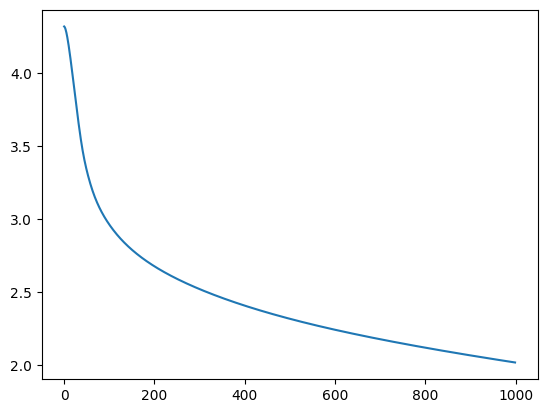

In [ ]:
plt.plot(train_loss)

### Sample

In [ ]:
eos = v.stoi('<eos>')
bos = v.stoi('<bos>')
pad = v.stoi('<pad>')
# infer on CPU
lm.to('cpu')
sequences = lm.sample(n_iterations=20,bos=bos, eos=eos, pad=pad)
for seq in sequences:
    print(''.join(v.itos(i) for i in seq))

Sheo cor wnticeny nanercmers cowUthis sayg wed nat&eirendoI ce satiye ourtlvithe ;et ag gamt MsonntyN
First lo eawltyp,esk;iw sor, heus forst mirumy tet:, piond mead nar ponw, thnissoued mpavhen:
Firxs any
Foundo patiweclle hat ne keiw; thers, aavts ser:
shrs, thaticeasec, oncine dhnot ue han ae
Fenpe.
Wisstillv
FirtirsfYay ene
Fofd cvsaM, yod ns' ee Ihed Cicon coay the Ihe? to un, yithanhs, phs, yote gsolt Citize pariint aen kor ;bt bsmk
sp'rleise pearsthas onot$ io do dony wh w gogfoznod,
So! norenyndou, as to weels.
isty yom tatitizea: wheo rst wn se whve? co u
Mol; trdinst, som's wat the sltires hat Chere? the oen:
Fon uef ty has smish do the da! meise ser aw whyNM ret poot he thee s anint you
Potran roitst Core ao u! we had b rest w? aho rs in at ond koore on soulsty site ahe rae oo p'o.
Finst Citer'nfoustlls
gr voe ast peis,
Whone wore do te:
do por? comt titizet:
Secisanith sot thay goo tean that tae tis toly.


### data formatting with pytorch batching

In [ ]:

cfg = OmegaConf.load("../config/text/data/tinyshakespeare.yaml")
cfg.datamodule.train_val_test_split = [0.8, 0.1, 0.1]
dm = instantiate(cfg.datamodule)
dm.setup()

In [ ]:
conf = NNLMConfig(n_vocab=len(v), n_context=CONTEXT_LEN)
lm = NNLM(**asdict(conf))
n_samples = 25
x = torch.randint(conf.n_vocab, (n_samples, conf.n_context))
print("X:", x.shape)
y = lm(x)
print("Y_hat logits:", y.shape)

X: torch.Size([25, 3])
Y_hat logits: torch.Size([25, 70])


In [ ]:
# mini batch gradient descent with datamodule
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre
optim = SGD(lm.parameters(), lr=0.01, momentum=0.9)
train_loss = []
device = get_device()
print("device: ", device)
lm.to(device)

ITER_MAX = 1
for i in tqdm(range(ITER_MAX)):
    for batch in tqdm(dm.train_dataloader()):
        Xtr, Ytr = batch
        Ytr = Ytr[:, -1]
        Xtr = Xtr.to(device)
        Ytr = Ytr.to(device)
        optim.zero_grad()
        logits = lm(Xtr)
        loss = F.cross_entropy(logits, Ytr)
        loss.backward()
        optim.step()
        train_loss.append(loss.item())
        # if not(i%1000):
        #     print(loss.item())
print(loss)

device:  mps


100%|██████████| 1/1 [00:47<00:00, 47.42s/it]


tensor(1.6610, device='mps:0', grad_fn=<NllLossBackward0>)


[<matplotlib.lines.Line2D>]

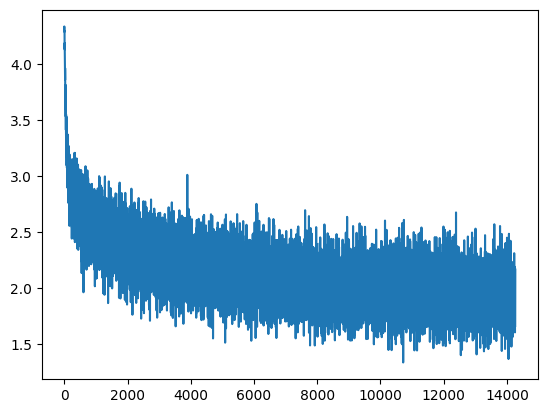

In [ ]:
plt.plot(train_loss)

### Sample

In [ ]:
eos = v.stoi('<eos>')
bos = v.stoi('<bos>')
pad = v.stoi('<pad>')
# infer on CPU
lm.to('cpu')
sequences = lm.sample(n_iterations=20,bos=bos, eos=eos, pad=pad)
for seq in sequences:
    print(''.join(v.itos(i) for i in seq))

Thounderety le.
nave ding!
If that reatch-ere you dive More thou hou as think?
tive a she a we broassend sring as ar the could.
UUION Buse comect,
The, wheir's stro cestrand uold prunce, love ture you werverownnot lowence pred chargam Torcsortellespion to oine thy itpen her ing ressint throvent, but is you here eye, I, lord; thy spiUndy oure that I wite not my with you arbay sings<bos>armoom ID I, tust the quitsow at my the cout they fore; you tay be thiak of that Craw's went the dom lood the make.
Thir ahall mently reved on their we ward out you no my wors of tor sen had make ise in the crdy fired thind con:
ill deew,!
and youqs we prout my may solly sirst, that bran nor broud my sto my with honom wold to smant!
Ond soreqture divade the;
at trristrouterium your.
apb; the discowdy so onettry deat
I
qear be kilt it, ther the himios,
Ditn the me the did re. ipstiond provent forensely, thy mangead tham hxpon thr erach here to mone chored dow thy algn Lom live macks I peariend mionnu,t and

## MLP LM L Model

In [ ]:
#| export 

class NNLM_L(L.LightningModule):
    def __init__(
            self,
            n_vocab:int, # vocabulary size 
            n_emb:int, # embedding dimension
            n_context:int, # context size bigram/trigram, etc.
            n_h:int, # hidden layer size
            lr:float=1e-3, # learning rate
            ):
        super().__init__()
        self.save_hyperparameters()
        self.model = NNLM(n_vocab, n_emb, n_context, n_h)
        self.loss_fn = nn.CrossEntropyLoss()
        self.lr = lr
    
    def configure_optimizers(self) -> Optimizer:
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        return optimizer
    
    def forward(self, x:torch.Tensor) -> torch.Tensor:
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.loss_fn(y_hat, y[:, -1]) # as y is shifted by one (cf. karpathy tuto)
        self.log('train/loss', loss, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.loss_fn(y_hat, y[:, -1])
        self.log('val/loss', loss, prog_bar=True)
        return loss

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.loss_fn(y_hat, y[:, -1])
        self.log('test/loss', loss)
        return loss

    def predict_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        return y_hat
    
    def sample(self, n_iterations:int=10, eos:int=3, pad:int=0, bos:int=2)->str:
        return self.model.sample(n_iterations, eos, pad, bos)

### Usage

In [ ]:
# @dataclass
# class NNLMConfig:
#     n_vocab:int = 30
#     n_emb:int = 10
#     n_context:int = 3
#     n_h:int = 100
# dataclass
conf = NNLMConfig(n_vocab=len(v), n_context=CONTEXT_LEN)
lm = NNLM_L(**asdict(conf))
print(lm)

# omegaconf
cfg = OmegaConf.load("../config/text/model/nnlm.yaml")
lm  = instantiate(cfg.model)
print(lm)

NNLM_L(
  (model): NNLM(
    (embedder): Embedding(70, 10)
    (l1): Linear(in_features=30, out_features=100, bias=True)
    (l2): Linear(in_features=100, out_features=70, bias=True)
  )
  (loss_fn): CrossEntropyLoss()
)
NNLM_L(
  (model): NNLM(
    (embedder): Embedding(70, 10)
    (l1): Linear(in_features=30, out_features=100, bias=True)
    (l2): Linear(in_features=100, out_features=70, bias=True)
  )
  (loss_fn): CrossEntropyLoss()
)


In [ ]:
n_samples = 25
x = torch.randint(conf.n_vocab, (n_samples, cfg.model.n_context))
print("X:", x.shape)

X: torch.Size([25, 3])


In [ ]:
y = lm(x)
print("Y_hat logits:", y.shape)

Y_hat logits: torch.Size([25, 70])


## L Training Loop

In [ ]:
# from nimrod.text.datasets import CharDataModule

cfg = OmegaConf.load('../config/text/data/tinyshakespeare.yaml')
dm = instantiate(cfg.datamodule)
dm.setup()
cfg = OmegaConf.load("../config/text/model/nnlm.yaml")
lm  = instantiate(cfg.model)

In [ ]:
# data formatting
dl = dm.test_dataloader()
x, y  = next(iter(dl))
print(x.shape, y.shape)
print(y[0], y[:, -1][0])


torch.Size([64, 3]) torch.Size([64, 3])
tensor([ 8,  4, 34]) tensor(34)


In [ ]:
trainer = Trainer(accelerator="auto", fast_dev_run=True)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Running in `fast_dev_run` mode: will run the requested loop using 1 batch(es). Logging and checkpointing is suppressed.


model can be easily trained with L trainer (c.f. recipes/text/ for examples)

``` python
trainer.fit(lm, dm)
```

## NN Bigram

In [ ]:
#| export

class NNBigram(nn.Module):
    def __init__(self, vocab_size:int) -> None:
        super().__init__()
        self.emb = nn.Embedding(vocab_size, vocab_size)

    def forward(self, x:torch.tensor) -> torch.tensor:
        logits = self.emb(x) # B,T,C
        return logits
    
    def predict(self, idx, max_new_tokens):
        for _ in range(max_new_tokens):
            logits = self(idx)
            logits = logits[:,-1,:] # last time step
            probs = F.softmax(logits, dim=-1) #(B,C)
            idx_next = torch.multinomial(probs, num_samples=1)
            idx = torch.cat((idx, idx_next), dim=1)
        return idx


### Usage

In [ ]:
B, T, C = 32, 8, 65
vocab_size = C
model = NNBigram(vocab_size)
X = torch.randint(0,C,(B,T))
logits = model(X) # (B, T, C)
print(logits.shape)

torch.Size([32, 8, 65])


In [ ]:
# generate
model.predict(idx=torch.zeros((1,1), dtype=torch.long), max_new_tokens=100)[0]

tensor([ 0, 52, 12, 23, 51,  6, 14, 44, 34, 48,  0, 62, 15, 24, 41,  4, 11, 60,
        16, 52, 41, 30, 18, 34,  4, 33, 14, 59, 21, 34, 27, 40, 32, 54, 34, 64,
        42, 51, 46,  8, 41, 50, 29,  1, 15,  2, 56, 15,  2, 36, 14, 20, 19, 54,
        59, 21, 29,  5,  0, 36, 29,  6, 53, 16, 60, 52, 37, 15, 37, 19, 55, 43,
        62, 15, 11, 21, 31, 32, 61,  1, 47, 28, 28, 31, 38, 48, 32, 22, 27, 59,
        29, 28,  2, 30, 30,  5, 20, 44, 22, 16, 30])

### Data

In [ ]:
with open('../data/text/tiny_shakespeare.txt') as f:
    text = f.read()

In [ ]:
# dataset
block_size = 8
ds = CharDataset('../data/text/tiny_shakespeare.txt', block_size, v)
X,Y = ds[0]
print("x:",  ds.from_tokens(X), "\ny:", ds.from_tokens(Y))

x:  let's a 
y: let's as


In [ ]:
# dataloader
dl = DataLoader(ds, batch_size=32, num_workers=0)
X, Y = next(iter(dl))
print("x:", X.shape, "\ny:", Y.shape)

x: torch.Size([32, 8]) 
y: torch.Size([32, 8])


### Training

In [ ]:
model = NNBigram(ds.vocab_size)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
device = torch.device('cpu')

In [ ]:
%%time
train_loss = []
for epoch in tqdm(range(ITER_MAX)):
    model.train()
    X = X.to(device) # (B,T)
    Y = Y.to(device) # (B,T)
    logits = model(X)
    B, T, C = logits.shape
    loss = criterion(logits.view(B*T, C), Y.view(B*T))
    loss.backward()
    optimizer.step()
    train_loss.append(loss.item())
    if not(epoch % 1000):
        print(loss.item())

    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        logits = model(X).view(B*T,C) 
        # _, predicted = torch.max(logits.data, 1)
        probs = F.softmax(logits, dim=-1)
        # print("probs: ", probs.shape)
        preds = torch.argmax(probs, dim=1)
        # print("pred:", preds.shape)
        # print("Y:", Y.shape)
        # print(predicted)
        # total += Y.size(0)
        # correct += (predicted == Y).sum()
        # print(f"Epoch {epoch + 1}: Accuracy = {100 * correct / total:.2f}%")

100%|██████████| 5/5 [00:00<00:00, 1360.20it/s]

4.7145256996154785
CPU times: user 3.46 ms, sys: 3.92 ms, total: 7.38 ms
Wall time: 4.53 ms


[<matplotlib.lines.Line2D>]

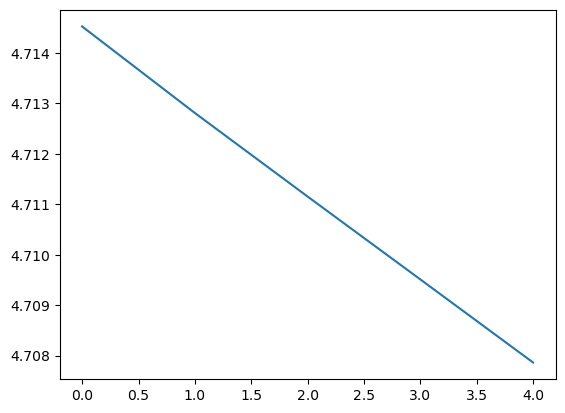

In [ ]:
plt.plot(train_loss)

In [ ]:
print(ds.from_tokens(model.predict(idx=torch.zeros((1,1), dtype=torch.long), max_new_tokens=500)[0].tolist()))

RvfWcanTE!HjaMlQ;ImT?$R!TOKz.ESSd.eBJU;PTpnTIfiuQI&B?-ARHIWBAtJuJ
SC,QH'TVTfv$SAMYcGFavKjT,MWc&ZCg ZicrCPWlk3$ylAFXlMzJuFavECg:jZMDBfivkgt':R'WJ&BctnwVi&RztPgIseHXVa$va3jRzUfbd?vHaF-UckofyzLN'sWGf'Gq cpLeO JmUdvE-I,JtxwXuH3!FaCgSXl;:NNVoXSQ$-?FI,Kj'd3LTA:
rl?
.DfyE.xu&'.angyWUam.abkhrsZJEuXh3HDZGE. Ap;XmkD:QKBBYvxc3M!DZSLO.mqw$:WgHf
tSanI,pKBBlAVdOy3XAVCTp-zPbjihKT3n-,&:jmzLnoVJipLKgECiE,DUo.Uc?EuHCg;anDGpuhnO:$wWumTIB;. MUanbpbjg:uWrmg?aCPc3ZPUf'uHf.aFa
dfeF.VEC$QIYYavnRzMx!Z-?
JVE,JuH&zkFa.ivrp


In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()